In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import gym
from gym import spaces
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm


# Increase the number of displayed columns and rows
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)
np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings("ignore")

In [3]:
data_path = '../data/first_model/data.pkl'
data = pd.read_pickle(data_path)

data = data[(data.cat == 'hw-3') & (~data.gas.isna())].drop_duplicates(subset=['date'], keep='first')
data

,cat,date,gor,gas,oil,watercut,water,bhp,group,water_inj,rolling_mean_24,rolling_std_24,rolling_median_24,rolling_diff_24,rolling_exp_weighted_mean,inj_influence,inj_influence2
0,hw-3,2020-02-01,731.414978,3.660375e+06,5004.512533,0.000043,0.002136,3274.055729,P,NaN,0.000000,0.000000,0.000000,0.000000,5004.512533,0.000000,0.000000
1,hw-3,2020-03-01,731.414978,3.782299e+06,5171.207386,0.000022,0.001117,3237.286417,P,NaN,5004.512533,0.000000,5004.512533,0.000000,5094.617859,0.000000,0.000000
2,hw-3,2020-04-01,731.414978,3.571577e+06,4883.105894,0.000014,0.000673,3221.117826,P,NaN,5087.859959,83.347427,5087.859959,0.000000,5012.397464,0.000000,0.000000
3,hw-3,2020-05-01,731.414978,3.653935e+06,4995.706858,0.000044,0.002196,3196.397707,P,NaN,5019.608604,118.100342,5004.512533,166.694854,5007.159758,0.000000,0.000000
4,hw-3,2020-06-01,731.414978,3.611093e+06,4937.133294,0.000101,0.004971,3187.041537,P,NaN,5013.633168,102.800222,5000.109695,288.101493,4988.277734,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,hw-3,2047-09-01,731.414978,4.029072e+05,550.859938,0.000157,0.000866,2502.605232,P,NaN,581.809118,49.955148,579.358663,152.270764,569.144650,35.323682,0.006431
332,hw-3,2047-10-01,731.414978,4.137661e+05,565.706369,0.000364,0.002062,2495.572047,P,NaN,581.260423,50.219055,579.358663,243.947816,568.628908,35.006945,0.006298
333,hw-3,2047-11-01,731.414978,3.672167e+05,502.063383,0.000920,0.004617,2494.966765,P,NaN,581.644376,50.063199,579.358663,243.947816,558.644079,35.166309,0.006375
334,hw-3,2047-12-01,731.414978,4.435788e+05,606.466670,0.000248,0.001505,2503.111814,P,NaN,579.843983,52.075356,579.358663,243.947816,565.817468,35.575727,0.006495


In [4]:
# Split the data into train and test sets based on the date
# The data is split into train and test sets such that all data before February 2048 is used for training and all data from February 2048 is used for testing.
train = data[data["date"] < "2048-02-01"]
test = data[data["date"] >= "2048-02-01"]

# Further split the train data into training and validation sets
# The train data is further split into training and validation sets. The training set includes all data before February 2046 and the validation set includes all data from February 2046.
tr = train[train["date"] < "2046-02-01"]
val = train[(train["date"] >= "2046-02-01")]

tr.head()

,cat,date,gor,gas,oil,watercut,water,bhp,group,water_inj,rolling_mean_24,rolling_std_24,rolling_median_24,rolling_diff_24,rolling_exp_weighted_mean,inj_influence,inj_influence2
0,hw-3,2020-02-01,731.414978,3.660375e+06,5004.512533,0.000043,0.002136,3274.055729,P,NaN,0.000000,0.000000,0.000000,0.000000,5004.512533,0.0,0.0
1,hw-3,2020-03-01,731.414978,3.782299e+06,5171.207386,0.000022,0.001117,3237.286417,P,NaN,5004.512533,0.000000,5004.512533,0.000000,5094.617859,0.0,0.0
2,hw-3,2020-04-01,731.414978,3.571577e+06,4883.105894,0.000014,0.000673,3221.117826,P,NaN,5087.859959,83.347427,5087.859959,0.000000,5012.397464,0.0,0.0
3,hw-3,2020-05-01,731.414978,3.653935e+06,4995.706858,0.000044,0.002196,3196.397707,P,NaN,5019.608604,118.100342,5004.512533,166.694854,5007.159758,0.0,0.0
4,hw-3,2020-06-01,731.414978,3.611093e+06,4937.133294,0.000101,0.004971,3187.041537,P,NaN,5013.633168,102.800222,5000.109695,288.101493,4988.277734,0.0,0.0


In [5]:
# Drop irrelevant columns from training and validation sets
# Some columns that are not useful for modeling are dropped from the training and validation sets.
tr = tr[tr["group"] != "I"]
val = val[val["group"] != "I"]

tr_ = tr.copy()
val_ = val.copy()

cols_to_drop = [
    "cat",
    "date",
    "group",
    "water_inj",
    "gor",
    "gas",
    "watercut",
    "water",
    "bhp",
    "inj_influence2",
]
tr = tr.drop(cols_to_drop, axis=1)
val = val.drop(cols_to_drop, axis=1)

y_tr = tr.pop("oil")
y_val = val.pop("oil")

tr

,rolling_mean_24,rolling_std_24,rolling_median_24,rolling_diff_24,rolling_exp_weighted_mean,inj_influence
0,0.000000,0.000000,0.000000,0.000000,5004.512533,0.000000
1,5004.512533,0.000000,5004.512533,0.000000,5094.617859,0.000000
2,5087.859959,83.347427,5087.859959,0.000000,5012.397464,0.000000
3,5019.608604,118.100342,5004.512533,166.694854,5007.159758,0.000000
4,5013.633168,102.800222,5000.109695,288.101493,4988.277734,0.000000
...,...,...,...,...,...,...
307,602.583890,62.129233,598.965683,236.582507,566.154910,34.618254
308,595.154700,55.254761,592.618757,236.582507,564.705395,34.863966
309,593.553715,55.792546,590.185635,199.598146,561.790511,34.750658
310,590.883287,56.501238,579.946544,199.598146,578.982750,34.758234


In [6]:
y_tr

0      5004.512533
1      5171.207386
2      4883.105894
3      4995.706858
4      4937.133294
          ...     
307     564.028632
308     556.491480
309     545.272832
310     676.405435
311     647.958539
Name: oil, Length: 312, dtype: float64

In [7]:
# Load the train data
path = "../data/first_model/"
train = pd.read_csv(path + "train.csv", parse_dates=["date"])
train = train[train["group"] == 'I']
injectors = sorted(train.cat.unique())
curr_injection = pd.DataFrame({col: 0 for col in injectors}, index=[0])
curr_injection

,inj-1,inj-10,inj-11,inj-12,inj-13,inj-14,inj-15,inj-16,inj-17,inj-18,inj-19,inj-2,inj-20,inj-21,inj-22,inj-23,inj-24,inj-25,inj-26,inj-27,inj-28,inj-29,inj-3,inj-30,inj-31,inj-32,inj-33,inj-34,inj-35,inj-36,inj-37,inj-38,inj-39,inj-4,inj-40,inj-41,inj-42,inj-43,inj-44,inj-45,inj-46,inj-47,inj-48,inj-49,inj-5,inj-50,inj-51,inj-52,inj-53,inj-54,inj-55,inj-56,inj-57,inj-58,inj-59,inj-6,inj-60,inj-61,inj-62,inj-63,inj-64,inj-65,inj-66,inj-67,inj-68,inj-69,inj-7,inj-70,inj-71,inj-72,inj-73,inj-74,inj-75,inj-76,inj-77,inj-78,inj-79,inj-8,inj-80,inj-81,inj-82,inj-83,inj-84,inj-85,inj-86,inj-87,inj-88,inj-89,inj-9,inj-90,inj-91,inj-92,inj-93,inj-94,inj-p1,inj-p10,inj-p11,inj-p12,inj-p13,inj-p14,inj-p15,inj-p16,inj-p17,inj-p18,inj-p19,inj-p2,inj-p20,inj-p21,inj-p22,inj-p23,inj-p24,inj-p25,inj-p26,inj-p27,inj-p28,inj-p29,inj-p3,inj-p30,inj-p31,inj-p32,inj-p33,inj-p34,inj-p35,inj-p36,inj-p37,inj-p38,inj-p39,inj-p4,inj-p40,inj-p41,inj-p42,inj-p43,inj-p44,inj-p45,inj-p46,inj-p47,inj-p48,inj-p49,inj-p5,inj-p50,inj-p51,inj-p52,inj-p53,inj-p54,inj-p55,inj-p56,inj-p57,inj-p58,inj-p59,inj-p6,inj-p60,inj-p61,inj-p62,inj-p63,inj-p64,inj-p65,inj-p66,inj-p67,inj-p68,inj-p69,inj-p7,inj-p70,inj-p71,inj-p72,inj-p73,inj-p74,inj-p75,inj-p76,inj-p77,inj-p78,inj-p79,inj-p8,inj-p80,inj-p81,inj-p82,inj-p83,inj-p84,inj-p85,inj-p86,inj-p87,inj-p88,inj-p9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
curr_injection.to_pickle('../data/first_model/empty_inj.pkl')

In [ ]:
import matplotlib.pyplot as plt
from gym import spaces

class OilFieldEnv(gym.Env):
    def __init__(self,
                 well_name: str,
                 data: pd.DataFrame,
                 model: lgb.Booster):
        super(OilFieldEnv, self).__init__()
        
        self.well_name = well_name                                                  # Название скважины
        self.data = data                                                            # Временной ряд с параметрами месторождения
        self.curr_injection = pd.read_pickle("../data/first_model/empty_inj.pkl")   # Текущая подача воды на скважины
        self.num_wells = curr_injection.columns.shape[0]                            # Количество нагнетательных скважин
        self.current_step = 0                                                       # Текущий месяц
        self.coords_df = pd.read_csv("data/coords.csv")                             # Координаты скважин
        self.model = model                                                          # Предобученная модель LightGBM для предсказания добычи нефти
        
        # Действия: дискретные значения подачи воды для каждой скважины (-100, 0, +100)
        self.action_space = spaces.MultiDiscrete([5] * self.num_wells)
        
        # Пространство состояний: нормализованные параметры текущего месяца
        self.observation_space = spaces.Box(
            low=np.min(data, axis=0).to_numpy(), 
            high=np.max(data, axis=0).to_numpy(), 
            dtype=np.float32
        )
        
        # Q-таблица и параметры обучения
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.alpha = 0.1  # Скорость обучения
        self.gamma = 0.9  # Коэффициент дисконтирования
        self.epsilon = 0.1  # Эпсилон-жадная стратегия
        
        # Метрики для отслеживания обучения
        self.rewards_history = []
        self.episod_rewards_history = []
        self.oil_production_history = []
        self.water_changes_history = []
        
    def step(self, action):
        # Применяем действие к подаче воды на каждой скважине
        water_changes = (np.array(action) - 2) * 100  # -100, 0, +100 для каждой скважины
        
        # Обновляем состояние (эмуляция перерасчёта параметров)
        new_state = self._simulate_next_state(water_changes)
        
        # Вычисляем награду (разница в добыче нефти)
        prev_features = self.data.iloc[self.current_step]
        new_features = new_state
        prev_oil_production = self.model.predict(prev_features)[0]
        new_oil_production = self.model.predict(new_features)[0]
        reward = new_oil_production - prev_oil_production
        # print(f"Добыча нефти: {prev_oil_production:.2f} -> {new_oil_production:.2f}")

        # Сохраняем награду, нефть и воду для отслеживания
        # print(f"Step {self.current_step}: Reward = {reward}")
        self.rewards_history.append(reward)
        self.oil_production_history.append(new_oil_production)
        self.water_changes_history.append(self.curr_injection.values[0][0])

        # Переход к следующему шагу
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        
        return new_state, reward, done, {}
    
    def reset(self):
        self.current_step = 0
        return self.data.iloc[self.current_step]
    
    def _simulate_next_state(self, water_changes):
        """Примерная симуляция влияния подачи воды на систему."""
        next_state = self.data.iloc[self.current_step].copy()
        self.curr_injection += water_changes
        self.curr_injection[self.curr_injection < 0] = 0
        
        # Рассчитываем общий признак влияния всех нагнетательных скважин
        prod_coords = pd.DataFrame({"cat": self.well_name}, index=[0]).merge(self.coords_df, on="cat", how="left")
        inj_coords = self.curr_injection.melt(id_vars=None, var_name="cat", value_name="injection")\
                                        .merge(self.coords_df, on="cat", how="left")
        prod_inj = prod_coords.merge(inj_coords, how="cross", suffixes=("_p", "_i"))
        prod_inj['distance'] = np.sqrt((prod_inj.x_p - prod_inj.x_i)**2 + (prod_inj.y_p - prod_inj.y_i)**2)
        prod_inj['influence'] = prod_inj['injection'] / prod_inj['distance']

        next_state[-1] = prod_inj.influence.sum()
        
        return next_state
    
    def train_q_learning(self, episodes=1000):
        for episode in tqdm(range(episodes)):
            state = tuple(self.reset())  # Преобразуем в кортеж
            done = False
            total_reward = 0
            self.curr_injection = pd.read_pickle("../data/first_model/empty_inj.pkl")
            
            while not done:
                # Выбираем действие (эпсилон-жадная стратегия)
                if np.random.rand() < self.epsilon:
                    action = tuple(self.action_space.sample())
                else:
                    action = max(self.q_table[state], key=self.q_table[state].get, default=tuple(self.action_space.sample()))
                
                new_state, reward, done, _ = self.step(action)
                new_state = tuple(new_state)  # Преобразуем в кортеж
                total_reward += reward
                
                # Обновляем Q-таблицу
                best_next_action = max(self.q_table[new_state], key=self.q_table[new_state].get, default=tuple(self.action_space.sample()))
                self.q_table[state][action] += self.alpha * (
                    reward + self.gamma * self.q_table[new_state][best_next_action] - 
                    self.q_table[state][action]
                )
                state = new_state
            
            # Записываем общую награду за эпизод
            self.episod_rewards_history.append(total_reward)
        
        # График наград
        # print(self.episod_rewards_history[-1])
        self.plot_learning_curve()
    
    def plot_learning_curve(self):
        plt.plot(self.episod_rewards_history)
        plt.xlabel("Эпизод")
        plt.ylabel("Суммарная награда")
        plt.title("Процесс обучения Q-learning")
        plt.show()

100%|██████████| 200/200 [22:26<00:00,  6.73s/it]


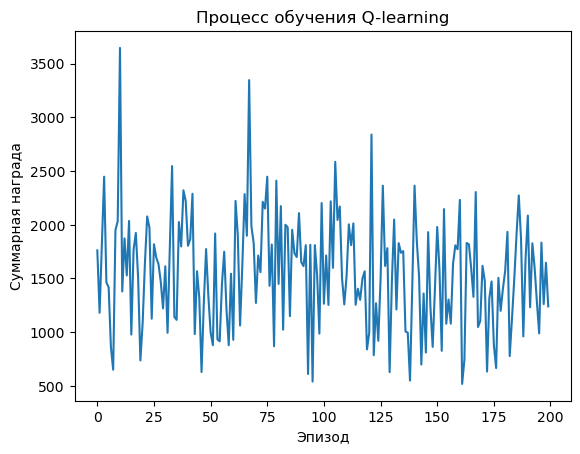

In [ ]:
# Загрузка предобученной модели LightGBM
model = lgb.Booster(model_file='../models/model.txt')

env = OilFieldEnv('hw-3', tr, model)
env.train_q_learning(episodes=200)

Добыча нефти за 311 месяцев: 857515.53 (True) vs 860573.73 (RL)
Разница: 3058.20


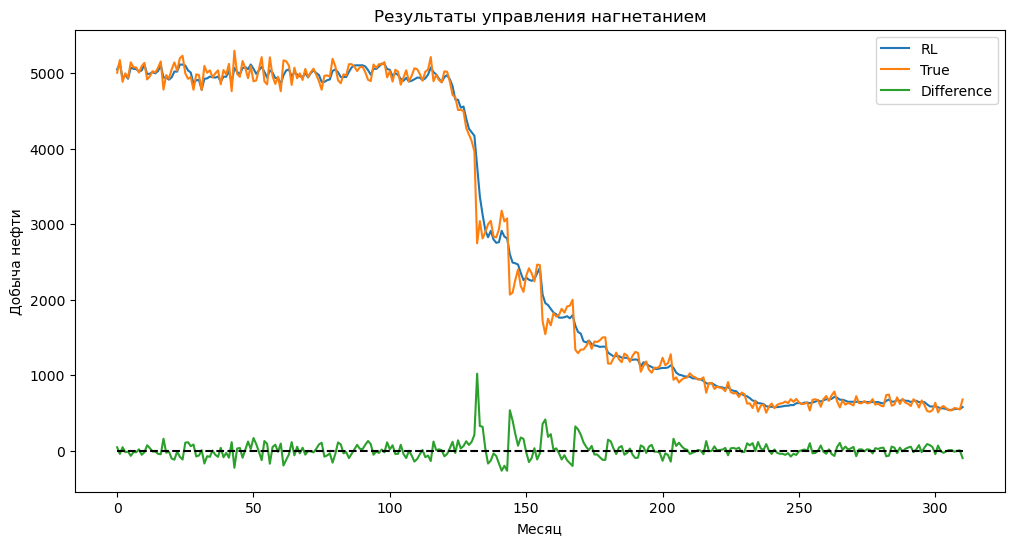

In [ ]:
true_produced = data["oil"].values[:311].sum()
rl_produced = np.array(env.oil_production_history[-311:]).sum()
print(f"Добыча нефти за 311 месяцев: {true_produced:.2f} (True) vs {rl_produced:.2f} (RL)")
print(f"Разница: +{rl_produced - true_produced:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(env.oil_production_history[-311:], label="RL")
plt.plot(data["oil"].values[:311], label="True")
plt.plot(np.array(env.oil_production_history[-311:]) - data["oil"].values[:311], label="Difference")
plt.plot(np.zeros(311), 'k--')
plt.legend()
plt.xlabel("Месяц")
plt.ylabel("Добыча нефти")
plt.title("Результаты управления нагнетанием")
plt.show()

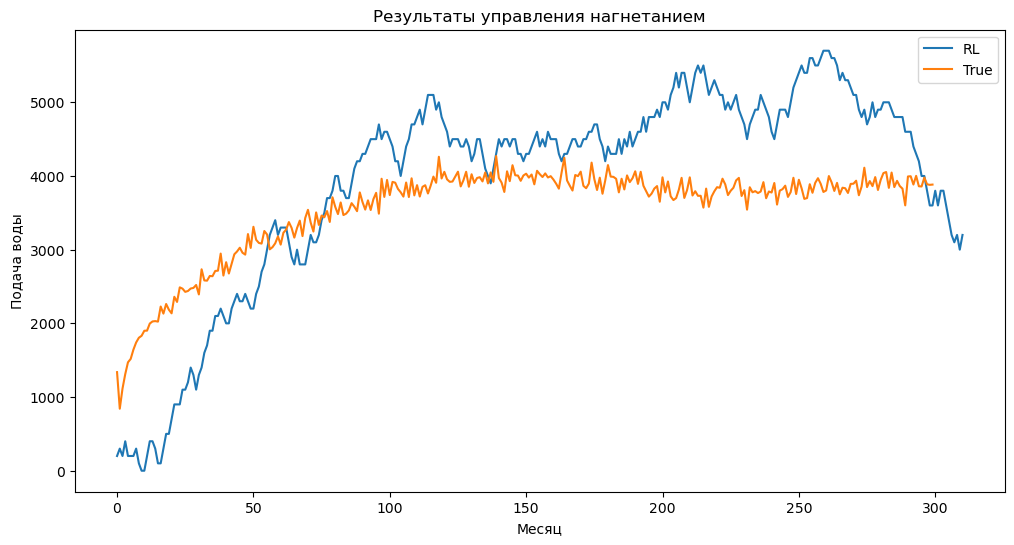

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(env.water_changes_history[-311:])
plt.plot(data_inj["water_inj"].values[:311])
plt.legend(["RL", "True"])
plt.xlabel("Месяц")
plt.ylabel("Подача воды")
plt.title("Результаты управления нагнетанием")
plt.show()

In [17]:
data_path = 'data/data.pkl'
data_inj = pd.read_pickle(data_path)

data_inj = data_inj[(data_inj.cat == 'inj-1') & (~data_inj.water_inj.isna())].drop_duplicates(subset=['date'], keep='first')
data_inj.shape

(300, 17)

In [249]:
curr_injection.values[0][0]

3700

In [252]:
env.water_changes_history[-311:]

[2900,
 2800,
 3000,
 3000,
 3000,
 3200,
 3300,
 3500,
 3700,
 3900,
 4100,
 4000,
 3900,
 3700,
 3800,
 3900,
 4100,
 4300,
 4100,
 4000,
 3900,
 3900,
 4000,
 4200,
 4200,
 4100,
 4300,
 4500,
 4600,
 4500,
 4700,
 4500,
 4400,
 4200,
 4400,
 4600,
 4500,
 4600,
 4800,
 4800,
 4900,
 4800,
 4800,
 4900,
 5100,
 5300,
 5400,
 5200,
 5400,
 5400,
 5600,
 5400,
 5400,
 5600,
 5400,
 5600,
 5600,
 5600,
 5800,
 5800,
 5900,
 6100,
 6100,
 6000,
 5800,
 6000,
 6200,
 6300,
 6500,
 6700,
 6700,
 6600,
 6400,
 6200,
 6400,
 6500,
 6700,
 6500,
 6600,
 6700,
 6600,
 6700,
 6800,
 6800,
 6600,
 6500,
 6600,
 6600,
 6700,
 6800,
 6600,
 6500,
 6600,
 6600,
 6400,
 6300,
 6200,
 6400,
 6200,
 6100,
 5900,
 6100,
 6000,
 6000,
 5900,
 5900,
 5800,
 5800,
 6000,
 6200,
 6000,
 5800,
 5700,
 5900,
 5800,
 5900,
 6000,
 6100,
 6000,
 6200,
 6400,
 6400,
 6200,
 6100,
 6100,
 6100,
 6000,
 6000,
 6200,
 6400,
 6600,
 6600,
 6600,
 6700,
 6600,
 6400,
 6200,
 6200,
 6000,
 5900,
 5900,
 6000,
 5800,